# Análisis de opiniones sobre Películas 

En esta sección se trabajará con un dataset del sitio <b>Rotten Tomatoes</b>, el cual consta de opiniones de la gente sobre alguna película, en texto en ingles. Se intentará predecir si la opinion de la persona es una opinion $positiva$ o $negativa$ (1 y -1) en base a un análisis de las palabras utilizadas en la opinion. Se trabaja ademas con operaciones de stopwords, stemming y lemmatization.

In [1]:
# Importar los datos y ver sus dimensiones
import urllib
import pandas as pd
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")
ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])
print train_df.shape
print test_df.shape
print train_df.head()
print test_df.tail()

#Contar cantidad de cada clase   
print "TRAINING-Cantidad clase negativa: ",train_df["Sentiment"].tolist().count(-1)
print "TRAINING-Cantidad clase positiva: ",train_df["Sentiment"].tolist().count(1)
print "TEST-Cantidad clase negativa: ",test_df["Sentiment"].tolist().count(-1)
print "TEST-Cantidad clase positiva: ",test_df["Sentiment"].tolist().count(1)

(3554, 2)
(3554, 2)
   Sentiment                                               Text
0         -1  everything's serious , poetic , earnest and --...
1         -1  narratively , trouble every day is a plodding ...
2          1  a truly wonderful tale combined with stunning ...
3          1  jason patric and ray liotta make for one splen...
4         -1  haneke keeps us at arm's length . guided more ...
      Sentiment                                               Text
3549          1  a fascinating documentary about the long and e...
3550          1  the filmmakers' eye for detail and the high st...
3551          1  throwing caution to the wind with an invitatio...
3552         -1  �a big , baggy , sprawling carnival of a movie...
3553          1  an incendiary , deeply thought-provoking look ...
TRAINING-Cantidad clase negativa:  1784
TRAINING-Cantidad clase positiva:  1770
TEST-Cantidad clase negativa:  1803
TEST-Cantidad clase positiva:  1751


En primera parte se carga los datos y se almacenan en un archivo local .csv. Luego se muestra un extracto del dataset donde se pueden ver opiniones ($text$) y su polaridad ($sentiment$).

La cantidad de datos en el training set de la clase negativa y positiva son 1784 y 1770 respectivamente. La cantidad de datos en el test set de la clase negativa y positiva son 1803 y 1751 respectivamente. Se puede observar que la cantidad de datos por clase es homogéneo, aportando a que el training set tenga un aprendizaje equitativo en cuanto a las clases.

In [2]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor(text):
    stemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ stemmer.stem(word.lower()) \
        for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words
def word_extractor_sin_stemming(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ word.lower() \
        for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

print "---------------------word_extractor---------------------"
print word_extractor("I love to eat cake")
print word_extractor("I love eating cake")
print word_extractor("I loved eating the cake")
print word_extractor("I do not love eating cake")
print word_extractor("I don't love eating cake")
# propias
print word_extractor("They are walking in the moon")
print word_extractor("I see a big foot")
print word_extractor("I saw my dog eat my cat")
print word_extractor("I have a dog called Pluto")
print word_extractor("I am eating cake")
print word_extractor("I eat lots of jellies")
print word_extractor("I eat a lots of cakes")

print "---------------------word_extractor_sin_stemming---------------------"
print word_extractor_sin_stemming("I love to eat cake")
print word_extractor_sin_stemming("I love eating cake")
print word_extractor_sin_stemming("I loved eating the cake")
print word_extractor_sin_stemming("I do not love eating cake")
print word_extractor_sin_stemming("I don't love eating cake")
# propias
print word_extractor_sin_stemming("They are walking in the moon")
print word_extractor_sin_stemming("I see a big foot")
print word_extractor_sin_stemming("I saw my dog eat my cat")
print word_extractor_sin_stemming("I have a dog called Pluto")
print word_extractor_sin_stemming("I am eating cake")
print word_extractor_sin_stemming("I eat lots of jellies")
print word_extractor_sin_stemming("I eat a lots of cakes")

---------------------word_extractor---------------------
 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake
 walk moon
 see big foot
 saw dog eat cat
 dog call pluto
 eat cake
 eat lot jelli
 eat lot cake
---------------------word_extractor_sin_stemming---------------------
 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake
 walking moon
 see big foot
 saw dog eat cat
 dog called pluto
 eating cake
 eat lots jellies
 eat lots cakes


Se puede observar que al aplicar el algoritmo $word\_extractor()$ captura el tronco léxico base de cada palabra en las distintas oraciones. En los 4 primeros ejemplos se obtiene el mismo tronco léxico para las oraciones, puesto que se trata solamente de palabras que se le agrega el "ing" o el "ed" al final. Tambien se observa que existe diferencia entre poner "do not" y "don't" obteniéndose distintas palabras como resultado, en el primer caso se consideran palabras separadas por lo que son eliminadas por la función <b>stopwords</b>, la cual elimina palabras que no aportan al significado, es decir, palabras sin información o de significado vacío como los artículos, los pronombres o las preposiciones. La importancia de borrar estas palabras es para hacer más eficiente el análisis de clasificación, puesto que así no se pierde tiempo procesando y guardando estas palabras en el algoritmo.

Si no se aplica <i>stemming</i>, las palabras no son reducidas a su tronco léxico por lo que quedan con su "extención" (-ing, -s, -ies, -es, -ed, entre otros).

In [3]:
# Funcion igual a la anterior, pero con lematizing en vez de stemming
def word_extractor2(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
            for word in word_tokenize(text.decode('utf-8','ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words
def word_extractor_sin_stop(text):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
        for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    words = ""
    for word in wordtokens:
        words+=" "+word
    return words
print word_extractor2("I love to eat cake")
print word_extractor2("I love eating cake")
print word_extractor2("I loved eating the cake")
print word_extractor2("I do not love eating cake")
print word_extractor2("I don't love eating cake")
#propias
print word_extractor2("They are walking in the moon")
print word_extractor2("I see a big foot")
print word_extractor2("I saw my dog eat my cat")
print word_extractor2("I have a dog called Pluto")
print word_extractor2("I am eating cake")
print word_extractor2("I eat lots of jellies")
print word_extractor2("I eat a lot of cakes")

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake
 walking moon
 see big foot
 saw dog eat cat
 dog called pluto
 eating cake
 eat lot jelly
 eat lot cake


Para el caso de la función $word\_extractor2()$ utiliza <i>lemmatization</i> el cual reduce las palabras asociándolas a alguna palabra del diccionario, eliminando los finales de las palabras que cambian el significado de estas, reduciendolas al una forma canónica.

Se puede ver la diferencia entre <i>lemmatization</i> y <i>stemming</i> en los ejemplos, ya que la primera deja intacto los finales -ed y -ing. Ambos eliminan los finales -es y -s, como es el caso de "jellies" a "jelly" y "cakes" a "cake", sin embargo la forma mediante <i>stemming</i> es mas reducida, ya que elimina también los finales -ed y -ing. 

In [4]:
# Representacion vectorial del texto de entrenamiento y el de pruebas
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0) #0 y 1
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0) # 0 y 1
vocab = vectorizer.get_feature_names() #se crea en base al texts train
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
dist2=list(np.array(features_test.sum(axis=0)).reshape(-1,))

# Se ordenan las palabras por cantidad
lista_train = zip(vocab, dist)
lista_train.sort(key=lambda x: x[1])
lista_train.reverse()
# Se ordenan las palabras por cantidad
lista_test = zip(vocab, dist2)
lista_test.sort(key=lambda x: x[1])
lista_test.reverse()

N = 10
pals_train = []
count_train =[]
pals_test = []
count_test = []
for i in range(N):
    tag, count = lista_train[i]
    pals_train.append(tag)
    count_train.append(count)
    tag_test, count_t = lista_test[i]
    pals_test.append(tag_test)
    count_test.append(count_t)    
print "Cantidad de palabras en el diccionario: %f"%(len(vocab))

a = [range(1,11),pals_train,count_train, ["#","#","#","#","#","#","#","#","#","#"], range(1,11), pals_test,count_test]
table =  zip(*a)
from tabulate import tabulate
print tabulate(table, headers=["Training","Palabra","Frecuencia","#", "Test","Palabra","Frecuencia"],  tablefmt="rst")
a = [pals_test,count_test]

Cantidad de palabras en el diccionario: 9663.000000
==========  =========  ============  ===  ======  =========  ============
  Training  Palabra      Frecuencia  #      Test  Palabra      Frecuencia
==========  =========  ============  ===  ======  =========  ============
         1  film                566  #         1  film                558
         2  movie               481  #         2  movie               540
         3  one                 246  #         3  one                 250
         4  like                245  #         4  ha                  238
         5  ha                  224  #         5  like                230
         6  make                183  #         6  story               197
         7  story               176  #         7  character           175
         8  character           163  #         8  time                165
         9  comedy              145  #         9  make                161
        10  time                143  #        10  comedy    

Se genera una representación vectorial de los datos de entrenamiento y de prueba, ajustado a los datos de entrenamiento, donde cada eje representa a una palabra, indicando un 1 si esa palabra está presente en la opinion de la persona, es decir, es un vector de las palabras que contiene la opinion de la persona.

La cantidad de palabras en el diccionario es 9663. Dentro de estas, las más frecuentes para el training set y para el test set son presentadas en la tabla anterior, donde las 10 palabras obtenidas en cada set son las mismas pero con distinta frecuencia. Se puede ver como las palabras más repetidas son las más relacionadas con la temática (películas) ya que son "film", "movie", "story","character","comedy". Hay algunas palabras bastante repetidas que no entregan mucho significado, tal como "ha" o como "one". 1 de cada 7 opiniones presenta la palabra "film". Se puede ver como una palabra por si sola no entrega el suficiente significado para determinar si una opinion es positiva o negativa, ya que estas 10 palabras más repetidas son un ejemplo de que no lo hacen. Se tiene el ejemplo de la palabra "like" la cual en un contexto distinto es utilizado con distintos propósitos, tales como "I like the movie" o "I didn't like the movie", por lo que por sí sola no entrega la información necesaria.

In [5]:
def representacion(forma):
    if forma == "normal":
        texts_train = [word_extractor_sin_stop(text) for text in train_df.Text]
        texts_test = [word_extractor_sin_stop(text) for text in test_df.Text]
    elif forma == "stem":
        texts_train = [word_extractor(text) for text in train_df.Text]
        texts_test = [word_extractor(text) for text in test_df.Text]
    elif forma == "lem":
        texts_train = [word_extractor2(text) for text in train_df.Text]
        texts_test = [word_extractor2(text) for text in test_df.Text]
    vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
    vectorizer.fit(np.asarray(texts_train))
    features_train = vectorizer.transform(texts_train)
    features_test = vectorizer.transform(texts_test)
    labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0) #0 y 1
    labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0) # 0 y 1
    return features_train,labels_train,features_test,labels_test

La función anterior es utilizada para generar la representación vectorial mediante los distintos procesos de reducción léxica.

In [6]:
from sklearn.metrics import classification_report,precision_recall_fscore_support
# Funcion que evalua el desempeño de un clasificador generico en el conjunto de entrenamiento y de pruebas
def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    
#Funcion que calcula los errores de un modelo
def errors(model,x,y,xt,yt): 
    yhat = model.predict(x)
    yhat_test = model.predict(xt)
    error = mis_class(yhat,y)
    terror = mis_class(yhat_test,yt)
    return error, terror
def mis_class(yhat,y):
    miss = [ 1 if(i != j) else 0  
            for i,j in zip(yhat,y)]
    return np.mean(miss) 

La función presentada anteriormente ($classification\_report()$) calcula 4 métricas (precision, recall, f1-score, support). Cada métrica es calculada de forma independiente para cada clase, donde el significado de <b> precision</b> es una tasa/razón entre los <i>true positive</i> y el resto de los positivos (<i>true positive + false positive</i>), en otras palabras representa la habilidad del clasificador en no etiquetar como clase "interna" a una clase "externa". El significado de <b>recall</b> tasa/razón entre los <i>true positive</i> y el resto de la clase "interna" (<i> true positive + false negative</i>), esto representa la habilidad del clasificador en no dejar fuera los ejemplos de la clase propia, es decir, etiquetar correctamente los de la clase "interna" . <b>f1-score</b> realiza un promedio harmónico/ponderado entre las métricas de precision y recall. Finalmente <b>support</b> entrega la cantidad de ejemplos asignadas a cada clase.

In [76]:
from sklearn.naive_bayes import BernoulliNB
def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model
errors_bayes = []
accuracy_bayes = []

tipos = ["normal","lem","stem"]
descripcion = ["WITHOUT STOP WORDS and WITH LEMM", "WITH LEMMATISATION","WITH STEMMING"]
for (r,d) in zip(tipos,descripcion):
    print d
    features_train,labels_train,features_test,labels_test = representacion(r)
    model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
    
    #calculan y guardan los errores de entrenamiento y prueba
    error,terror = errors(model,features_train,labels_train,features_test,labels_test)
    errors_bayes.append([error,terror])
    print "Error (Misclassification) Training: %f"%(error)
    print "Error (Misclassification) Test: %f"%(terror)
    
    #valores de retornos agregados por datos requeridos en grafico
    acc = model.score(features_test,labels_test)
    acct = model.score(features_train,labels_train)
    prec_rec = precision_recall_fscore_support(labels_test,model.predict(features_test))[:1]
    datos = [acc,acct] + list(prec_rec[0])
    accuracy_bayes.append(datos)

WITHOUT STOP WORDS and WITH LEMM
Training Accuracy BernoulliNB: 0.955262
Test Accuracy BernoulliNB: 0.748663
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

Error (Misclassification) Training: 0.044738
Error (Misclassification) Test: 0.251266
WITH LEMMATISATION
Training Accuracy BernoulliNB: 0.958638
Test Accuracy BernoulliNB: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

Error (Misclassification) Training: 0.041362
Error (Misclassification) Test: 0.261396
WITH STEMMING
Training Accuracy BernoulliNB: 0.942881
Test Accuracy BernoulliNB: 0.747819
Detailed Analysis Testing Re

En la celda anterior se ajustó un modelo <b>Naive Bayes</b>, el cual presenta sus desempeños en los distintos sets, además de información extra acerca del desempeño en cada clase. Agregando al final el error con función de pérdida <i> misclassification</i> para cada set.

<i>stemming</i> tiene un desempeño mejor en el test set, entregando una precisión del <b>74,78 %</b>, por otro lado <i>lemmatisation</i> por otro lado se comporta mejor en el training set. En base a la información detallada sobre resultados en el test set se puede ver que <i>stemming</i> tiene un mejor comportamiento, esto es explicado ya que como se vio anteriormente este proceso realiza un corte a la palabra mas brusco, reduciéndola más que <i>lemma</i>, dejando información más significativa en cuanto al léxico (mas "pura"). El proceso de <i>lemmatisation</i> al dejar terminaciones como -ing, -ed, produce un sesgo sobre los datos, ya que si está presente una palabra en el training set como "walking", el modelo la asignará distinta a la palabra "walk", perdiéndo la información de que estas palabras significan lo mismo. Para el caso de <i>stemming</i> a estas palabras le asignará la misma probabilidad ya que son consideradas la misma ("walk"). 

Para el caso de filtrar <b>stopwords</b> en el proceso del modelo este presenta un mejor desempeño sobre el test set, esto es contradictorio a lo esperado ya que se espera que al eliminar estas palabras que no entregan información el modelo pueda predecir con mejor exactitud. Esta contradicción se puede explicar por los supuestos de naive bayes, ya que la probabilidad de clasificar una frase, es la probabilidad independiente de cada una de las palabras presentes en la frase, con esto en mente se pudo tener el caso que palabras sin información como "and", "of", "the", "or" ayudan a clasificar correctamente la frase, siendo algo totalmente aleatorio dependiendo del training set, ya que esas palabras podrían ir en cualquier contexto, positivas o negativas.

In [20]:
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

[ 0.1115585  0.8884415] interesting both as a historical study and as a tragic love story .

[ 0.06890124  0.93109876] the year's happiest surprise , a movie that deals with a real subject in an always surprising way .

[ 0.06894851  0.93105149] watching war photographer , you come to believe that nachtwey hates the wars he shows and empathizes with the victims he reveals .

[ 0.98249908  0.01750092] anemic , pretentious .

[ 0.73498718  0.26501282] though frida is easier to swallow than julie taymor's preposterous titus , the eye candy here lacks considerable brio .

[ 0.94243663  0.05756337] the film is reasonably entertaining , though it begins to drag two-thirds through , when the melodramatic aspects start to overtake the comedy .

[ 0.55127663  0.44872337] to call this one an eventual cult classic would be an understatement , and woe is the horror fan who opts to overlook this goofily endearing and well-lensed gorefest .

[ 0.00590384  0.99409616] a stylish but steady , and ultim

ver lo de arriba

In [75]:
from sklearn.naive_bayes import MultinomialNB
def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MULTINOMIAL")
    return model
errors_multi= []
accuracy_multi = []

tipos = ["normal","lem","stem"]
descripcion = ["WITHOUT STOP WORDS and WITH LEMM", "WITH LEMMATISATION","WITH STEMMING"]
for (r,d) in zip(tipos,descripcion):
    print d
    features_train,labels_train,features_test,labels_test = representacion(r) #representacion
    model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test) #se ejecuta el modelo
    
    #calculan y guardan los errores de entrenamiento y prueba
    error,terror = errors(model,features_train,labels_train,features_test,labels_test)
    errors_multi.append([error,terror])
    print "Error (Misclassification) Training: %f"%(error)
    print "Error (Misclassification) Test: %f"%(terror)
    
    #valores de retornos agregados por datos requeridos en grafico
    acc = model.score(features_test,labels_test)
    acct = model.score(features_train,labels_train)
    prec_rec = precision_recall_fscore_support(labels_test,model.predict(features_test))[:1]
    datos = [acc,acct] + list(prec_rec[0])
    accuracy_multi.append(datos)

WITHOUT STOP WORDS and WITH LEMM
Training Accuracy MULTINOMIAL: 0.955543
Test Accuracy MULTINOMIAL: 0.747537
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.75      0.75      0.75      3554

Error (Misclassification) Training: 0.044457
Error (Misclassification) Test: 0.252392
WITH LEMMATISATION
Training Accuracy MULTINOMIAL: 0.959482
Test Accuracy MULTINOMIAL: 0.740782
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

Error (Misclassification) Training: 0.040518
Error (Misclassification) Test: 0.259145
WITH STEMMING
Training Accuracy MULTINOMIAL: 0.942319
Test Accuracy MULTINOMIAL: 0.749789
Detailed Analysis Testing Re

En la celda anterior se ajustó un modelo <b>Naive Bayes Multinomial</b>, el cual presenta sus desempeños en los distintos sets, además de información extra acerca del desempeño en cada clase. Agregando al final el error con función de pérdida misclassification para cada set.

<i>stemming</i> tiene un desempeño mejor en el test set entregando una precisión del <b>74,98 %</b>, <i>lemmatisation</i> por otro lado se comporta mejor en el training set, similar al caso de Naive Bayes discutido anteriormente. Se presentan los mismos argumentos del porqué <i>stemming</i> se comporta mejor sobre el test set, debido al reduce de las palabras a una estructura más pura. <i>lemma</i> se comporta mejor sobre el training set debido a que este set está sesgado hacia la información con las palabras reducidas según <i>lemma</i>.

Para este caso el filtrar el eliminado de <b>stopwords</b> también produce un efecto contradictorio a lo esperado, como es el caso de Naive Bayes. Por lo que se piensa que es un suceso casual producido por el training set.

In [18]:
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

[ 0.32421864  0.67578136] this franchise has not spawned a single good film . the crap continues .

[ 0.90392584  0.09607416] comes across as a fairly weak retooling .

[ 0.64892822  0.35107178] flavorful and romantic , you could call this how martha got her groove back -- assuming , that is , she ever had one to begin with .

[ 0.95974086  0.04025914] if swimfan does catch on , it may be because teens are looking for something to make them laugh .

[ 0.55947259  0.44052741] the film grows on you . and how .

[ 0.92402891  0.07597109] that zhang would make such a strainingly cute film -- with a blind orphan at its center , no less -- indicates where his ambitions have wandered .

[ 0.57232973  0.42767027] these people wouldn't know subtle characterization if it put on a giant furry monster costume and then gave them a lapdance .

[ 0.52960649  0.47039351] summer's far too fleeting to squander on offal like this .

[ 0.58510856  0.41489144] it's so underwritten that you can't figure out

ver lo de arriba iwal

In [25]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xt,yt):
    start_t = time.time()
    Cs = [0.01,0.1,1,1,10,100,1000]
    for C in Cs:
        print "Usando C= %f"%C
        model = LogisticRegression(penalty='l2',C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"LOGISTIC")
        #Se calculan y muestran los errores
        error,terror = errors(model,x,y,xt,yt)
        print "Error (Misclassification) Training: %f"%(error)
        print "Error (Misclassification) Test: %f"%(terror)
print "EFFECT OF C IN THE MODEL"
features_train,labels_train,features_test,labels_test = representacion("lem")
do_LOGIT(features_train,labels_train,features_test,labels_test)

EFFECT OF C IN THE MODEL
Usando C= 0.010000
Training Accuracy LOGISTIC: 0.784468
Test Accuracy LOGISTIC: 0.678863
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.67      0.73      0.70      1803
          -       0.69      0.63      0.66      1751

avg / total       0.68      0.68      0.68      3554

Error (Misclassification) Training: 0.215532
Error (Misclassification) Test: 0.321047
Usando C= 0.100000
Training Accuracy LOGISTIC: 0.892234
Test Accuracy LOGISTIC: 0.719111
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.72      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

Error (Misclassification) Training: 0.107766
Error (Misclassification) Test: 0.280810
Usando C= 1.000000
Training Accuracy LOGISTIC: 0.989589
Test Accuracy LOGISTIC: 0.721362
Detailed Analysis Testing Resu

Para el caso anterior se ajusta un modelo de <b>Regresión Logística Regularizado</b>, donde recibe de parámetro un valor <i>C</i> el cual se analiza su efecto en el desempeño del modelo en el test set y en el training set. Este parámetro <i>C</i> representa el rango de la penalización del modelo a equivocarse sobre el conjunto del cual se entrena, es decir, el error sobre el. Para valores pequeños de <i>C</i> el modelo está permite bajos valores de penalización, por lo que el modelo es mas relajado en permitir un mayor error sobre el training set, mostrándo esto en que el desempeño sobre el training set es el peor. Con un <i>C</i> muy bajo se tiene que el modelo pasa a ser muy relajado por lo que presenta un menor desempeño en el test set. 
Cuando <i>C</i> es mayor a 10, se pueden ver modelos no relajados, es decir con una mayor penalización sobre el error en el training set, por lo que el modelo se ajusta a este set produciéndo un error de entrenamiento de 0 (desempeño 100%). Se puede visualizar esta transición en lo mostrado anteriormente, ya que a medida que aumenta el parámetro, el desempeño en el training set también.

In [74]:
#SEGUN LO DE ARRIBA SE ESCOGE C = 1
from sklearn.linear_model import LogisticRegression
def do_LOGIT_C(x,y,xt,yt,c=1):
    start_t = time.time()
    model = LogisticRegression(penalty='l2',C=c)
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"LOGISTIC")
    return model

errors_logit = []
accuracy_logit = []

tipos = ["normal","lem","stem"]
descripcion = ["WITHOUT STOP WORDS and WITH LEMM", "WITH LEMMATISATION","WITH STEMMING"]
for r, d in zip(tipos,descripcion): #for para mostrar el efecto de distintas representaciones
    print d
    features_train,labels_train,features_test,labels_test =  representacion(r)
    model = do_LOGIT_C(features_train,labels_train,features_test,labels_test) #se ajusta un modelo LOGISTICO
    
    #calculan y guardan los errores de entrenamiento y prueba
    error,terror = errors(model,features_train,labels_train,features_test,labels_test) 
    errors_logit.append([error,terror])
    print "Error (Misclassification) Training: %f"%(error)
    print "Error (Misclassification) Test: %f"%(terror)
    
    #valores de retornos agregados por datos requeridos en grafico
    acc = model.score(features_test,labels_test)
    acct = model.score(features_train,labels_train)
    prec_rec = precision_recall_fscore_support(labels_test,model.predict(features_test))[:1] #solo pre y rec
    datos = [acc,acct] + list(prec_rec[0])
    accuracy_logit.append(datos)

WITHOUT STOP WORDS and WITH LEMM
Training Accuracy LOGISTIC: 0.987901
Test Accuracy LOGISTIC: 0.736279
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.73      0.74      1803
          -       0.73      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

Error (Misclassification) Training: 0.012099
Error (Misclassification) Test: 0.263647
WITH LEMMATISATION
Training Accuracy LOGISTIC: 0.989589
Test Accuracy LOGISTIC: 0.721362
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.72      1803
          -       0.72      0.72      0.72      1751

avg / total       0.72      0.72      0.72      3554

Error (Misclassification) Training: 0.010411
Error (Misclassification) Test: 0.278559
WITH STEMMING
Training Accuracy LOGISTIC: 0.981148
Test Accuracy LOGISTIC: 0.735153
Detailed Analysis Testing Results ...
        

En la celda superior se ajustó un modelo de Regresión Lineal Regularizada con parámetro <i>C </i> igual a 1, mostrando el efecto de utilizar <i>stemming </i> o <i>lemmatisation</i> en la representación de los datos. Para esto se puede ver que la representación mediante <i>stemming</i> se comporta mejor sobre el test set, produciendo un buen desempeño en todas las métricas presentadas anteriormente (precision, recall, f1-score), además de presentar un desempeño sobre el test set de <b>73,51 %</b>. Esto se explica al igual que en los casos anteriores de Naive Bayes, debido a que este proceso es mejor ya que se trabaja con información pura (palabras en su tronco léxico).

El filtrar el proceso de <b>stopwords</b> al igual que en los casos anteriores presenta un mejor comportamiendo sobre el test set, debido al mismo razonamiento de que es producido por que en este caso el training set genera una serie de probabilidades en las palabras que elimina el <b>stopwords</b> las cuales benefician al momento de ver el desempeño sobre el test set. 

In [24]:
from sklearn.svm import LinearSVC
def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,1,10,100,1000]
    for C in Cs:
        print "El valor de C que se esta probando: %f"%C
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")
print "EFFECT OF C IN THE MODEL"
features_train,labels_train,features_test,labels_test = representacion("lem")
do_SVM(features_train,labels_train,features_test,labels_test)

EFFECT OF C IN THE MODEL
El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.884637
Test Accuracy SVM: 0.715170
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.989589
Test Accuracy SVM: 0.723614
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 1.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.710667
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.70      0.71      1803
         

Para lo presentado en la celda anterior se tiene un modelo <b>SVM</b> el cual es ajustado al training set analizando su comportamiendo en base al parámetro de penalización <i>C</i>, donde este valor representa el error presente en el ajuste del modelo sobre el training set, en otras palabras, representa el grado de suavidad del modelo. Para <i>C</i> pequeños el modelo penaliza menos los errores sobre el ajuste en el trainng set, traduciendose en un modelo mas suave (</i>soft-margin</i>) el cual permite errores sobre los datos en los cuales se ajusta. Para <i>C</i> grande la penalización sobre el error en el conjunto con el cual se entrena es mayor, traduciéndose en un modelo mas estricto (<i>hard-margin</i>) sobre el training set.

Para este dataset de opiniones sobre películas se puede ver el efecto esperado del parámetro <i>C</i> sobre el modelo <b>SVM</b>, donde con valores pequeños el desempeño sobre el training set es bajo comparado con otro valor de <i>C</i>. Para <i>C</i> mayor a 1 el modelo es de <i>hard-margin</i>, es decir es estricto sobre el training set, traduciéndose en un desempeño de 100% sobre este set y con un menor desempeño sobre el test set, produciéndo un claro <i>overfitting</i>.

In [73]:
#SEGUN LO DE ARRIBA SE ESCOGE C = 0.1
from sklearn.svm import LinearSVC
def do_SVM_C(x,y,xt,yt,c=0.1):
    model = LinearSVC(C=c)
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"SVM")
    return model
errors_svm = []
accuracy_svm = []

tipos = ["normal","lem","stem"]
descripcion = ["WITHOUT STOP WORDS and WITH LEMM", "WITH LEMMATISATION","WITH STEMMING"]
for r, d in zip(tipos,descripcion): #for para mostrar el efecto de distintas representaciones
    print d
    features_train,labels_train,features_test,labels_test =  representacion(r)
    model = do_SVM_C(features_train,labels_train,features_test,labels_test) #es ejecutado SVM retornando el modelo ajustado
    
    #calculan y guardan los errores de entrenamiento y prueba
    error,terror = errors(model,features_train,labels_train,features_test,labels_test) 
    errors_svm.append([error,terror])
    print "Error (Misclassification) Training: %f"%(error)
    print "Error (Misclassification) Test: %f"%(terror)
    
    #valores de retornos agregados por datos requeridos en grafico
    acc = model.score(features_test,labels_test)
    acct = model.score(features_train,labels_train)
    prec_rec = precision_recall_fscore_support(labels_test,model.predict(features_test))[:1]
    datos = [acc,acct] + list(prec_rec[0])
    accuracy_svm.append(datos)

WITHOUT STOP WORDS and WITH LEMM
Training Accuracy SVM: 0.987901
Test Accuracy SVM: 0.738249
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

Error (Misclassification) Training: 0.012099
Error (Misclassification) Test: 0.261677
WITH LEMMATISATION
Training Accuracy SVM: 0.989589
Test Accuracy SVM: 0.723614
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

Error (Misclassification) Training: 0.010411
Error (Misclassification) Test: 0.276308
WITH STEMMING
Training Accuracy SVM: 0.981992
Test Accuracy SVM: 0.731213
Detailed Analysis Testing Results ...
             precision    recall  f1-s

En la celda superior se ajusta un modelo de <b>SVM</b> con parámetro <i>C</i> igual a 0.1 para ver el efecto de realizar distintas representaciones verbales sobre el dataset. Para el caso de la representación según <i>stemming</i> se tiene un mejor desempeño sobre el test set, entregando una precisión de <b>73,12%</b>, esto se atribuye a la misma explicación ya dada anteriormente con los otros modelos.

Para el caso de filtrar <b>stopwords</b> en el proceso del modelo este presenta un mejor desempeño sobre el test set, caso contradictorio a lo esperado al igual que en los 3 modelos ya descritos anteriormente, esto deja claro que el training set tiene un sesgo a realizar un ajuste mejor sobre el test set cuando son utilizadas estas palabras que no entrengan información. Un ejemplo de este suceso podría presentarse que en el caso en que el conector "and" aparezca en una gran cantidad de opiniones <i>positivas</i>, esto ayudará a que el modelo prediga mejor sobre el test set, pero es un caso específico de los dataset.

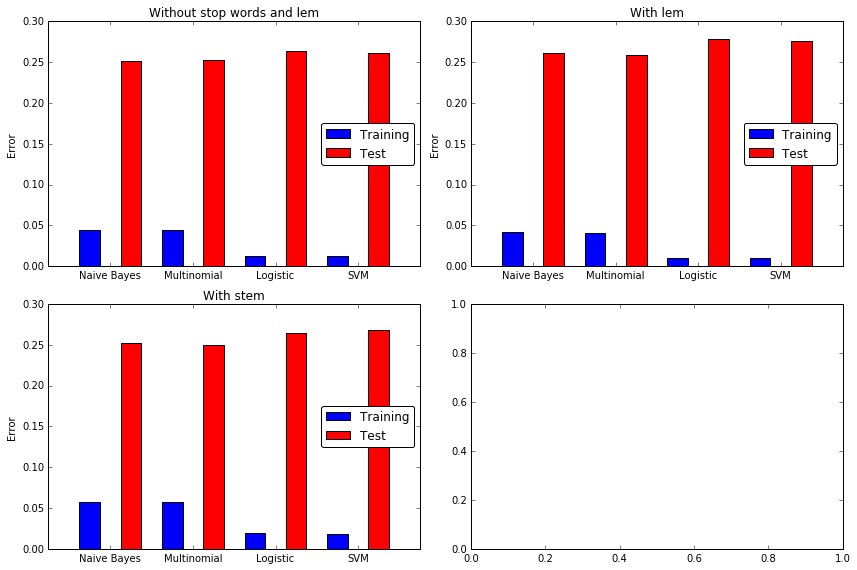

In [27]:
#Construir grafico comparativo.
import matplotlib.pyplot as plt
nostop = errors_bayes[0] + errors_multi[0] + errors_logit[0] + errors_svm[0]
lem = errors_bayes[1] + errors_multi[1] + errors_logit[1] + errors_svm[1]
stem = errors_bayes[2] + errors_multi[2] + errors_logit[2] + errors_svm[2]

#PARA COMPARAR LOS EFECTOS DE STEM Y LEM
colors = ['b','r','b','r','b','r','b','r']
f, axarr = plt.subplots(2, 2, figsize=(12,8) )
barlist = axarr[0, 0].bar(range(8), nostop, width  = 0.5, align = "center", color = colors)
axarr[0, 0].set_title('Without stop words and lem')
axarr[0, 0].set_xticks([0.5,2.5,4.5,6.5])
axarr[0, 0].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[0, 0].set_ylabel('Error')
axarr[0, 0].legend(barlist, ["Training","Test"], loc="center right", fancybox= True)

axarr[0, 1].bar(range(8), lem, width  = 0.5, align = "center", color = colors)
axarr[0, 1].set_title('With lem')
axarr[0, 1].set_xticks([0.5,2.5,4.5,6.5])
axarr[0, 1].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[0, 1].set_ylabel('Error')
axarr[0, 1].legend(barlist, ["Training","Test"], loc="center right", fancybox= True)

axarr[1, 0].bar(range(8), stem, width  = 0.5, align = "center", color = colors)
axarr[1, 0].set_title('With stem')
axarr[1, 0].set_xticks([0.5,2.5,4.5,6.5])
axarr[1, 0].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[1, 0].set_ylabel('Error')
axarr[1, 0].legend(barlist, ["Training","Test"],loc="center right", fancybox= True)


f.tight_layout() #separar los subplot
plt.show()

En este item se presentan los gráficos que resumen el error según misclassification de todos los modelos ajustados sobre el training set del dataset de <b>Rotten Tomatoes</b>. Donde se asigna un error máximo cuando el modelo se equivoca en predecir una etiqueta, para este caso por ejemplo es cuando el modelo predice una etiqueta como <i>positiva</i> siendo que es <i>negativa</i>. Se puede ver que para el caso en que la representación según  <i>lemmatisation</i>  los modelos Logístico y SVM presentan un <i>overfitting</i>  ya que estos se ajustan mucho al training set, en esta representación el modelo que mejor se comporta presentando el menor error en el test set y con menor overfitting es el de <b>Naive Bayes</b>. 

Para el caso que se utiliza la representación según <i>stemming</i> los modelos Logístico y SVM también presentan este sobre-ajuste sobre el training set. El modelo que mejor se comporta sobre test set según esta representación es el <b>Multinomial</b>.

Se puede observar que cuando se usa lematization <b>sin stopwords</b>, se obtiene un error levemente mas bajo, lo cual es contradictorio puesto que como bien se ha mencionado anteriormente, stopword elimina las palabras que no aportan significado a la hora de clasificar, por lo que no aplicar este procedimiento podria producir un sesgo significativo.
Para este caso en especifico, como no se aplica stopword, el sesgo que se produce justamente ayuda un poco a bajar el error de test, es decir, a clasificar correctamente. Esto se puede explicar con el training set, ya que puede que ciertas palabras sin significado, como conectores, esten mas presentes en clases positivas o negativas segun sea el caso, por lo que considerar estas palabras ciertamente provoca una mejora en la clasificación. 

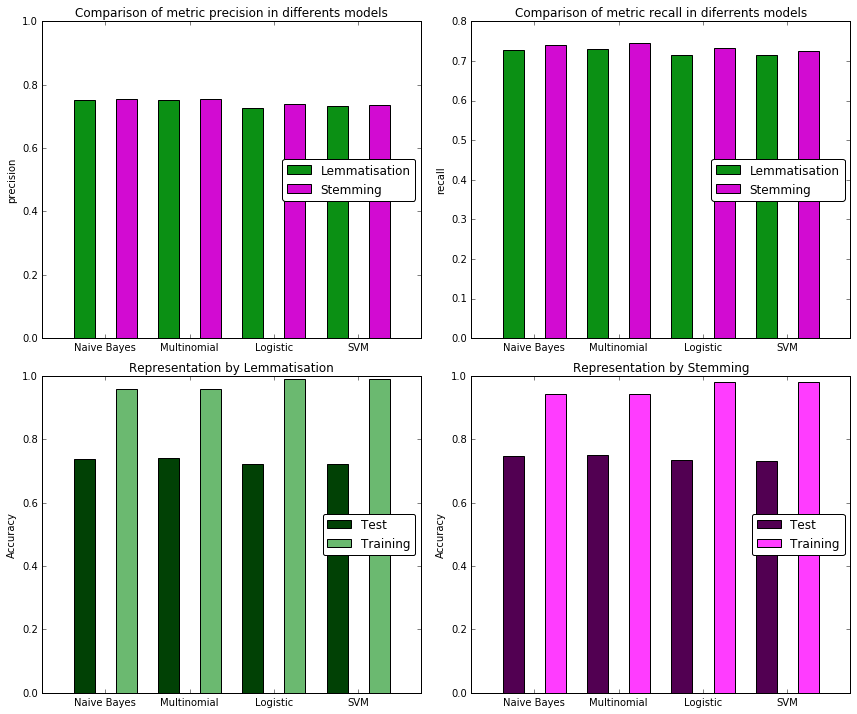

In [90]:
import matplotlib.pyplot as plt
#DECODIFAN LOS DATOS ALMACENADOS EN LAS CELDAS ANTERIORES
nostop_ac = accuracy_bayes[0] + accuracy_multi[0] + accuracy_logit[0] + accuracy_svm[0]
lem_ac = [accuracy_bayes[1]] + [accuracy_multi[1]] + [accuracy_logit[1]] + [accuracy_svm[1]]
stem_ac = [accuracy_bayes[2]] + [accuracy_multi[2]] + [accuracy_logit[2]] + [accuracy_svm[2]]    

precision = []
recall = []
accuracy_lem = []
accuracy_stem = []
for lem,stem in zip(lem_ac,stem_ac):
    accuracy_lem += lem[:2]  
    accuracy_stem += stem[:2]
    precision += [lem[2]]+[stem[2]] 
    recall+= [lem[3]]+[stem[3]] 
#PARA COMPARAR LOS EFECTOS DE STEM Y LEM
f, axarr = plt.subplots(2, 2, figsize=(12,10) )
colors = ['#0B9014','#D20BD2']*4
barlist = axarr[0, 0].bar(range(8), precision, width  = 0.5, align = "center", color = colors)
axarr[0, 0].set_title('Comparison of metric precision in differents models')
axarr[0, 0].set_xticks([0.5,2.5,4.5,6.5])
axarr[0, 0].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[0, 0].set_ylim([0,1])
axarr[0, 0].set_ylabel('precision')
axarr[0, 0].legend(barlist, ["Lemmatisation","Stemming"],loc="center right", fancybox= True)

axarr[0, 1].bar(range(8), recall, width  = 0.5, align = "center", color = colors)
axarr[0, 1].set_title('Comparison of metric recall in diferrents models')
axarr[0, 1].set_xticks([0.5,2.5,4.5,6.5])
axarr[0, 1].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[0, 1].set_ylabel('recall')
axarr[0, 1].legend(barlist, ["Lemmatisation","Stemming"],loc="center right", fancybox= True)

colors = ['#014105','#6BB970']*4
barlist = axarr[1, 0].bar(range(8), accuracy_lem, width  = 0.5, align = "center", color = colors)
axarr[1, 0].set_title('Representation by Lemmatisation')
axarr[1, 0].set_xticks([0.5,2.5,4.5,6.5])
axarr[1, 0].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[1, 0].set_ylabel('Accuracy')
axarr[1, 0].legend(barlist, ["Test","Training"], loc="center right", fancybox= True)

colors = ['#520052','#FF3CFF']*4
barlist = axarr[1, 1].bar(range(8), accuracy_stem, width  = 0.5, align = "center", color = colors)
axarr[1, 1].set_title('Representation by Stemming')
axarr[1, 1].set_xticks([0.5,2.5,4.5,6.5])
axarr[1, 1].set_xticklabels(('Naive Bayes', 'Multinomial', 'Logistic','SVM'))
axarr[1, 1].set_ylabel('Accuracy')
axarr[1, 1].legend(barlist, ["Test","Training"],loc="center right", fancybox= True)


f.tight_layout() #separar los subplot
plt.show()